# Animación del Tránsito del Exoplaneta KELT-3 b  
# Exoplanet Transit Animation — KELT-3 b

---

## 🇪🇸 Descripción académica (Español)

Este **Jupyter Notebook** presenta un código en Python desarrollado para la **visualización y animación del tránsito de un exoplaneta** frente a su estrella anfitriona, utilizando **datos fotométricos observacionales reales** procesados con el software **EXOTIC (EXOplanet Transit Interpretation Code)**.

El objetivo principal de este cuaderno es **vincular directamente la curva de luz observada con una representación geométrica y temporal del tránsito**, permitiendo:

- Analizar de forma intuitiva la relación entre la **disminución de flujo** y la **posición proyectada del planeta**
- Facilitar la **divulgación científica** y la **interpretación pedagógica** de observaciones de tránsito
- Generar material visual reproducible para **presentaciones académicas, educación y ciencia ciudadana**

La animación incluye:
- Una **curva de luz normalizada** en función de la fase orbital
- Un **modelo geométrico simplificado** del sistema estrella–planeta
- Un **disco estelar coloreado automáticamente** según la temperatura efectiva de la estrella
- **Créditos científicos y de autoría** colocados fuera del área de datos
- Exportación opcional del resultado como **video MP4**

---

## 🇬🇧 Academic Description (English)

This **Jupyter Notebook** contains a Python-based workflow designed for the **visualization and animation of an exoplanet transit** across its host star, using **real observational photometric data** processed with **EXOTIC (EXOplanet Transit Interpretation Code)**.

The primary goal is to **directly link the observed transit light curve with a geometric and time-synchronized visualization of the transit**, enabling:

- Intuitive interpretation of the relationship between **flux decrease** and **planetary position**
- Effective **scientific outreach** and **pedagogical use**
- Creation of reproducible visual material for **academic presentations, education, and citizen science**

The animation includes:
- A **normalized transit light curve** as a function of orbital phase
- A **simplified geometric model** of the star–planet system
- A **stellar disk automatically colored** according to stellar effective temperature
- **Scientific and authorship credits** outside the data area
- Optional **MP4 video export**

---

## 🧭 Diagrama conceptual del tránsito  
## 🧭 Conceptual Transit Diagram



       Observador
           ↑
           |
           |
    ┌─────────────────┐
    │   Disco estelar  │   ← Flujo observado
    │       ★★★★      │
    │     ★★★★★★★    │
    │   ★★★★★●★★★★★  │  ← Planeta en tránsito
    │     ★★★★★★★    │
    │       ★★★★      │
    └─────────────────┘
           |
           |
    Disminución de flujo
    (curva de luz)



**Interpretación / Interpretation:**

- El **planeta** bloquea una fracción del disco estelar
- La **profundidad del tránsito** depende de \( (R_p / R_*)^2 \)
- El **tiempo y la forma del tránsito** están ligados a:
  - Periodo orbital
  - Inclinación orbital
  - Radio relativo planeta–estrella

---

## ▶️ Cómo emplear este cuaderno  
## ▶️ How to use this notebook

### 🇪🇸 Instrucciones (Español)

1. **Ubique los archivos de datos** dentro de una carpeta de trabajo:
   - Archivo `.txt` generado por EXOTIC (curva de luz)
   - Archivo `.json` con parámetros estelares y orbitales

2. **Configure la variable `BASE_FOLDER`** para que apunte a dicha carpeta.

3. Edite las variables:
   - `OBSERVER`
   - `AFILIATION`  
   para reflejar la autoría de la observación.

4. Ejecute las celdas en orden:
   - Carga de funciones
   - Lectura de datos
   - Generación de la animación

5. (Opcional) Active `EXPORT_MP4 = True` para generar un video MP4 listo para difusión.

---

### 🇬🇧 Instructions (English)

1. **Place the data files** in a working directory:
   - EXOTIC-generated `.txt` light curve file
   - `.json` file containing stellar and orbital parameters

2. **Set the `BASE_FOLDER` variable** to point to that directory.

3. Edit the variables:
   - `OBSERVER`
   - `AFILIATION`  
   to reflect the observer’s authorship.

4. Run the notebook cells sequentially:
   - Function definitions
   - Data loading
   - Animation generation

5. (Optional) Set `EXPORT_MP4 = True` to generate an MP4 video suitable for dissemination.

---

## 👤 Autor / Author

**Julio Vannini**  
Sección de Estrellas Variables  
Liga Iberoamericana de Astronomía  
**SEV / LIADA**

---

## 📜 Licencia / License

Este código se distribuye bajo la licencia:

### **Creative Commons Attribution 4.0 International (CC BY 4.0)**  
https://creativecommons.org/licenses/by/4.0/

### Permite / Allows:
- Uso académico, educativo y profesional
- Modificación y adaptación del código
- Redistribución

### Requiere / Requires:
- **Reconocimiento explícito de la autoría original**
- Indicación de modificaciones si se realizan

---

## 📚 Créditos científicos / Scientific Credits

- **Zellem et al. 2020**, *Publications of the Astronomical Society of the Pacific*, 132:054401  
  https://ui.adsabs.harvard.edu/abs/2020PASP..132e4401Z/abstract

- **EXOTIC — EXOplanet Transit Interpretation Code**  
- **NASA Exoplanet Watch**

---

> *Este cuaderno está orientado a la astronomía observacional, la ciencia ciudadana y la educación universitaria.*


In [1]:
import re
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from matplotlib.animation import FuncAnimation, FFMpegWriter


In [2]:
def parse_header_kv(line: str):
    if "=" not in line:
        return {}
    _, payload = line.split("=", 1)
    parts = [p.strip() for p in payload.split(",") if p.strip()]
    out = {}
    for p in parts:
        m = re.match(r"([^=]+)=\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)", p)
        if m:
            out[m.group(1).strip()] = float(m.group(2))
    return out


def read_exotic_txt(path: str):
    header = {}
    data_lines = []
    with open(path, "r", encoding="utf-8", errors="replace") as f:
        for raw in f:
            line = raw.strip()
            if not line:
                continue
            if line.startswith("#"):
                if line.startswith("#PRIORS="):
                    header["priors"] = parse_header_kv(line)
                elif line.startswith("#RESULTS="):
                    header["results"] = parse_header_kv(line)
                elif line.startswith("#EXOPLANET_NAME="):
                    header["exoplanet_name"] = line.split("=", 1)[1].strip()
                elif line.startswith("#STAR_NAME="):
                    header["star_name"] = line.split("=", 1)[1].strip()
                continue
            data_lines.append(line)

    data = np.genfromtxt(data_lines, delimiter=",", dtype=float)
    if data.ndim == 1:
        data = data.reshape(1, -1)

    t = data[:, 0]       # BJD_TDB
    flux = data[:, 1]    # Flux
    err = data[:, 2]     # Error
    return header, t, flux, err


def read_inits_json(path: str):
    with open(path, "r", encoding="utf-8") as f:
        j = json.load(f)
    pp = j.get("planetary_parameters", {})

    stellar = {
        "star_name": pp.get("Host Star Name", None),
        "teff_k": pp.get("Star Effective Temperature (K)", None),
    }
    orbital = {
        "planet_name": pp.get("Planet Name", None),
        "period_days": pp.get("Orbital Period (days)", None),
        "rp_rs": pp.get("Ratio of Planet to Stellar Radius (Rp/Rs)", None),
        "a_rs": pp.get("Ratio of Distance to Stellar Radius (a/Rs)", None),
        "inc_deg": pp.get("Orbital Inclination (deg)", None),
    }
    return stellar, orbital


def teff_to_rgb(teff_k: float):
    """
    Aproximación visual (tipo blackbody) para color estelar.
    Retorna (r,g,b) en [0..1].
    """
    T = teff_k / 100.0

    if T <= 66:
        r = 255.0
    else:
        r = 329.698727446 * ((T - 60.0) ** -0.1332047592)
        r = np.clip(r, 0.0, 255.0)

    if T <= 66:
        g = 99.4708025861 * np.log(T) - 161.1195681661
    else:
        g = 288.1221695283 * ((T - 60.0) ** -0.0755148492)
    g = np.clip(g, 0.0, 255.0)

    if T >= 66:
        b = 255.0
    elif T <= 19:
        b = 0.0
    else:
        b = 138.5177312231 * np.log(T - 10.0) - 305.0447927307
        b = np.clip(b, 0.0, 255.0)

    return (r / 255.0, g / 255.0, b / 255.0)


def fold_phase_days(t, t0, period):
    dt = t - t0
    return (dt + 0.5 * period) % period - 0.5 * period


def projected_xy(dt_days, period_days, a_rs, inc_deg):
    n = 2.0 * np.pi / period_days
    inc = np.deg2rad(inc_deg)
    x = a_rs * np.sin(n * dt_days)
    y = -a_rs * np.cos(inc) * np.cos(n * dt_days)
    return x, y


In [6]:
# === Base folder ===
# Interactive configuration (English / Español)

print("Exoplanet Transit Animation – Interactive Configuration")
print("Animación del Tránsito de Exoplanetas – Configuración Interactiva")

OBSERVER = input("Observer name / Nombre del observador:\n> ").strip()

AFILIATION = input("Observer affiliation / Afiliación del observador:\n> ").strip()

BASE_FOLDER = input(
    "Enter the full path where the data files are located / "
    "Ingrese la ruta completa donde se encuentran los archivos de datos:\n> "
).strip()

if not BASE_FOLDER.endswith("/"):
    BASE_FOLDER += "/"

JSON_FILE = input("Archivo JSON / JSON filename:\n> ").strip()

AAVSO_REPORT = input("Reporte EXOTIC AAVSO / EXOTIC's AAVSO Report:\n> ").strip()

INIT_JSON_PATH = BASE_FOLDER + JSON_FILE
AAVSO_TXT_PATH = BASE_FOLDER + AAVSO_REPORT

# === Ventana de fase ===
PHASE_MIN, PHASE_MAX = -0.05, 0.05

# === Créditos ===
CREDIT_COLOR = "#BBBBBB"
CREDIT_LINE_2 = "Data processed with the EXOplanet Transit Interpretation Code (EXOTIC - Zellem et al. 2020) - Exoplanet Watch"
CREDIT_LINE_3 = "Notebook and Animation: Julio Vannini (SEV/LIADA) 2026"

# === Export MP4 ===
EXPORT_MP4 = True
OUTPUT_MP4 = os.path.join(BASE_FOLDER, "transit_window.mp4")
FPS = 30
DPI = 170
BITRATE = 2500


Exoplanet Transit Animation – Interactive Configuration
Animación del Tránsito de Exoplanetas – Configuración Interactiva


Observer name / Nombre del observador:
>  Julio Vannini
Observer affiliation / Afiliación del observador:
>  SEV - LIADA
Enter the full path where the data files are located / Ingrese la ruta completa donde se encuentran los archivos de datos:
>  /home/ungaman/Documents/Astronomia/MeowStar/Exoplanetas/Kelt-3 b/19Ene2026/
Archivo JSON / JSON filename:
>  inits_19_01_2026__12_45_44.json
Reporte EXOTIC AAVSO / EXOTIC's AAVSO Report:
>  AAVSO_KELT-3 b_19-01-2026.txt


In [4]:
stellar, orbital_json = read_inits_json(INIT_JSON_PATH)
header, t, flux, err = read_exotic_txt(AAVSO_TXT_PATH)

pri = header.get("priors", {})
res = header.get("results", {})

period = float(pri.get("Period", orbital_json.get("period_days", 2.0)))
t0 = float(res.get("Tc", np.median(t)))
rp_rs = float(res.get("Rp/R*", pri.get("Rp/R*", orbital_json.get("rp_rs", 0.1))))
inc_deg = float(res.get("inc", pri.get("inc", orbital_json.get("inc_deg", 88.0))))
a_rs = float(pri.get("a/R*", orbital_json.get("a_rs", 6.0)))

star_name = stellar.get("star_name") or header.get("star_name") or "Host Star"
planet_name = orbital_json.get("planet_name") or header.get("exoplanet_name") or "Planet"
teff_k = float(stellar.get("teff_k") or 6000.0)
star_rgb = teff_to_rgb(teff_k)

# Normalizar
med = np.nanmedian(flux)
flux_n = flux / med if np.isfinite(med) and med != 0 else flux
err_n = err / med if np.isfinite(med) and med != 0 else err

# Orden temporal
idx = np.argsort(t)
t, flux_n, err_n = t[idx], flux_n[idx], err_n[idx]
phase = fold_phase_days(t, t0, period)

# Filtrar ventana
win = (phase >= PHASE_MIN) & (phase <= PHASE_MAX)
t_w = t[win]
flux_w = flux_n[win]
err_w = err_n[win]
phase_w = phase[win]

if len(t_w) < 3:
    raise RuntimeError("Muy pocos puntos dentro de [-0.05, 0.05]. Ajusta PHASE_MIN/MAX o revisa datos.")

idx2 = np.argsort(t_w)
t_w, flux_w, err_w, phase_w = t_w[idx2], flux_w[idx2], err_w[idx2], phase_w[idx2]


## Celdas siguientes / Next cells
Ejecuta las siguientes celdas secuencialmente para cargar los datos, generar la animacion, y exportar el video en formato MP4

Run the following cells sequentially to load data, generate the animation,and export the MP4 video.


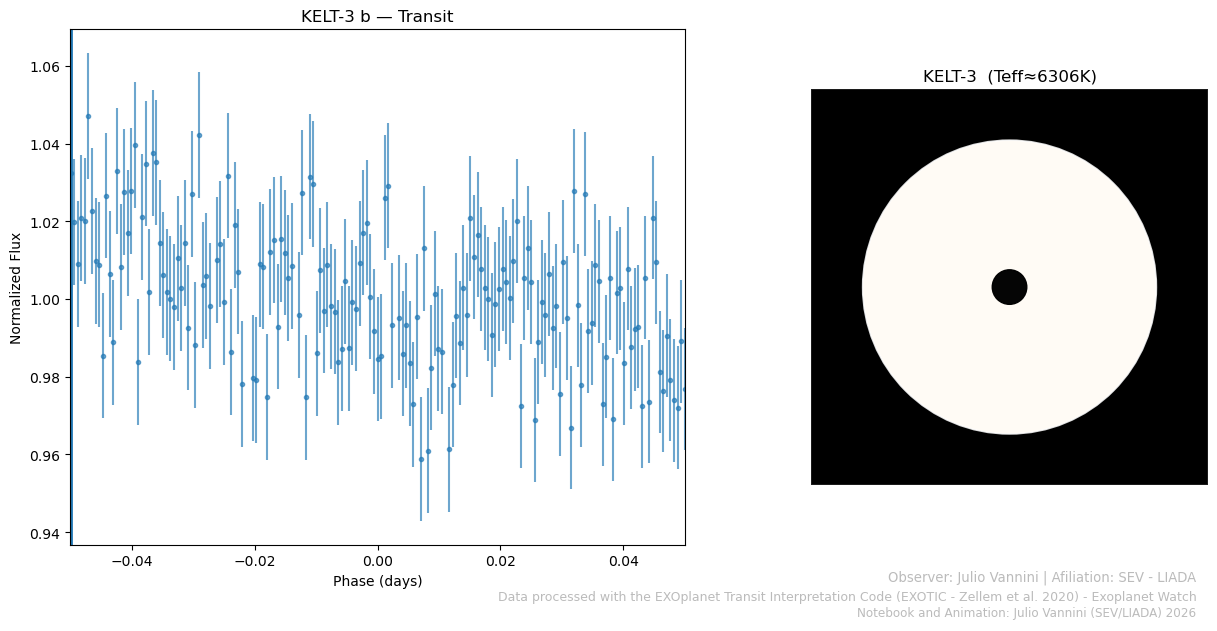

MP4 guardado como: /home/ungaman/Documents/Astronomia/MeowStar/Exoplanetas/Kelt-3 b/19Ene2026/transit_window.mp4


In [7]:
fig = plt.figure(figsize=(12.5, 6.8))
gs = fig.add_gridspec(
    2, 2,
    height_ratios=[20, 2.4],
    width_ratios=[1.55, 1.0],
    hspace=0.05,
    wspace=0.25
)

# Curva de luz
ax_lc = fig.add_subplot(gs[0, 0])
ax_lc.errorbar(phase_w, flux_w, yerr=err_w, fmt=".", alpha=0.65)
ax_lc.set_xlim(PHASE_MIN, PHASE_MAX)
ax_lc.set_xlabel("Phase (days)")
ax_lc.set_ylabel("Normalized Flux")
ax_lc.set_title(f"{planet_name} — Transit")
vline = ax_lc.axvline(phase_w[0], lw=2)

# Panel estrella/planeta
ax_tr = fig.add_subplot(gs[0, 1])
ax_tr.set_aspect("equal")
LIM = 1.35
ax_tr.set_xlim(-LIM, LIM)
ax_tr.set_ylim(-LIM, LIM)
ax_tr.axis("off")
ax_tr.set_title(f"{star_name}  (Teff≈{teff_k:.0f}K)")

# Fondo cuadrado negro + marco sutil
ax_tr.add_patch(
    Rectangle(
        (-LIM, -LIM),
        2 * LIM,
        2 * LIM,
        facecolor="black",
        edgecolor="#222222",
        linewidth=1.2,
        zorder=0
    )
)

# Disco estelar (color automático)
ax_tr.add_patch(Circle((0, 0), 1.0, facecolor=star_rgb, edgecolor="none", zorder=1))
ax_tr.add_patch(Circle((0, 0), 1.0, fill=False, edgecolor="white", lw=1.2, alpha=0.85, zorder=2))

# Planeta
planet = Circle((0, 0), rp_rs, facecolor="black", edgecolor="black", alpha=0.98, zorder=3)
ax_tr.add_patch(planet)

# Lower-third negro (fuera del área de datos/animación), esquina inferior derecha (3 líneas)
ax_cred = fig.add_subplot(gs[1, :])
ax_cred.axis("off")
ax_cred.set_facecolor("black")

ax_cred.text(
    0.99, 0.72,
    f"Observer: {OBSERVER} | Afiliation: {AFILIATION}",
    ha="right", va="center",
    fontsize=9.5, color=CREDIT_COLOR,
    transform=ax_cred.transAxes
)
ax_cred.text(
    0.99, 0.40,
    CREDIT_LINE_2,
    ha="right", va="center",
    fontsize=9.0, color=CREDIT_COLOR,
    transform=ax_cred.transAxes
)
ax_cred.text(
    0.99, 0.14,
    CREDIT_LINE_3,
    ha="right", va="center",
    fontsize=8.6, color=CREDIT_COLOR,
    transform=ax_cred.transAxes
)

def update(i):
    vline.set_xdata([phase_w[i], phase_w[i]])
    px, py = projected_xy(t_w[i] - t0, period, a_rs, inc_deg)
    planet.center = (px, py)
    return vline, planet

ani = FuncAnimation(fig, update, frames=len(t_w), interval=40, blit=False)

fig.subplots_adjust(left=0.06, right=0.97, top=0.92, bottom=0.05)
plt.show()

# Export MP4
if EXPORT_MP4:
    writer = FFMpegWriter(fps=FPS, bitrate=BITRATE, metadata={"title": f"{planet_name} transit"})
    ani.save(OUTPUT_MP4, writer=writer, dpi=DPI)
    print(f"MP4 guardado como: {OUTPUT_MP4}")
